# DL Survival - Ventilation Outcomes
 Updated 21/11/21

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
import datetime as dt
from datetime import timedelta
import json
import miceforest as mf
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 1. Data cleaning

- Import MIMIC III data
- Review column unique values, assign correct data types
- Impute missing values


### 1.1: Importing data

In [2]:
df = pd.read_csv('mimic_combined.csv')

In [3]:
pd.set_option('display.max_columns', None)
print(df.shape)
df.head(10)

(12332, 110)


,Unnamed: 0,hb,subject_id,tricuspid,alt,plt,bg_temp,ventrate,insurance,creatinine,ckd,crp,insulin,specimen,hospital_expire_flag,ext_time,pud,los,admission_type,inr_1,sodium,hba1c,bilirubin_indirect,diab_cc,ethnicity,t2dm,dtoutput,fibrinogen,cabg,hadm_id,mi,admission_location,fio2,ffp,first_careunit,liver_mild,admittime,malig,pco2,height,baseexcess,rheum,po2,bleed_time,reint_time,plts,neutrophils,intime,bilirubin_direct,dischtime,bilirubin_total,infection,alp,ph,free_calcium,sbp,diab_un,hematocrit,magnesium,glucose,vent_array,smoking,cvd,pulmonary,tidalvol,chloride,rr,ggt,dod,t1dm,cryo,inr,potassium,pvd,aids,icustay_seq,copd,wcc,liver_severe,albumin,meanbp,gender,mit,dementia,arrhythmia,language,bicarb,hr,ptt,marital_status,bun,weight,reintubation,ast,last_careunit,deathtime,aortic,cardiac_index,ccf,lymphocytes,outtime,dbp,prbc,lactate,spo2,paraplegia,temp,pt,aado2,met_ca
0,0,"[{'charttime': datetime.datetime(2111, 2, 17, ...",29491,0,[],"[{'charttime': datetime.datetime(2111, 2, 17, ...",[],[],Private,"[{'charttime': datetime.datetime(2111, 2, 17, ...",0,[],[],[],0,2111-02-16 13:00:00,0,1.0424,ELECTIVE,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",[],[],0,white,0,[],[],0,173798,0,PHYS REFERRAL/NORMAL DELI,[],[],CSRU,0,2111-02-16 07:15:00,0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",167.64,"[{'charttime': datetime.datetime(2111, 2, 16, ...",0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],NaN,[],[],2111-02-16 10:20:19,[],2111-02-21 15:49:00,[],"[{'suspected_infection_time': None, 'antibioti...",[],"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",0,[],[],"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'starttime': datetime.datetime(2111, 2, 16, ...",0,0,0,[],"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",[],NaN,0,[],"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",0,0,1,0,"[{'charttime': datetime.datetime(2111, 2, 17, ...",0,[],"[{'charttime': datetime.datetime(2111, 2, 16, ...",M,0,0,0,ENGL,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",[],DIVORCED,"[{'charttime': datetime.datetime(2111, 2, 17, ...",69.50,0,[],CSRU,NaN,1,[],0,[],2111-02-17 11:21:23,"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],[],"[{'charttime': datetime.datetime(2111, 2, 16, ...",0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],[],0
1,1,"[{'charttime': datetime.datetime(2192, 4, 20, ...",26775,0,[],"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],[],Medicare,"[{'charttime': datetime.datetime(2192, 4, 20, ...",0,[],[],[],0,2192-04-20 15:00:00,0,1.2855,ELECTIVE,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",[],[],0,white,0,[],"[{'charttime': datetime.datetime(2192, 4, 20, ...",1,197759,0,PHYS REFERRAL/NORMAL DELI,[],[],CSRU,0,2192-04-20 07:15:00,0,"[{'charttime': datetime.datetime(2192, 4, 20, ...",157.48,"[{'charttime': datetime.datetime(2192, 4, 20, ...",0,"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],NaN,[],"[{'charttime': datetime.datetime(2192, 4, 20, ...",2192-04-20 09:59:48,[],2192-04-24 13:23:00,[],"[{'suspected_infection_time': None, 'antibioti...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",0,"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'starttime': datetime.datetime(2192, 4, 20, ...",0,0,0,[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",[],NaN,0,[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",0,0,1,1,"[{'charttime': date

#### 1.1.1: Column lists

In [4]:
#view and reorder columns
cols = list(df.columns)
new_cols = ['Unnamed: 0','hadm_id','subject_id','gender','ethnicity','marital_status','insurance','language','aortic','mit','tricuspid',
            'pulmonary','cabg','temp','bg_temp','hr','spo2','rr','sbp','dbp','meanbp','weight','height','cardiac_index','pt','ptt',
            'inr','inr_1','fibrinogen','hb','hematocrit','plts','wcc','lymphocytes','neutrophils','alp','ast','alt','ggt',
            'bilirubin_indirect','bilirubin_direct','bilirubin_total','chloride','magnesium','potassium','crp','bleed_time','albumin',
            'creatinine','free_calcium','sodium','bicarb','bun','hba1c','glucose','lactate','po2','pco2','baseexcess','ph','aado2',
            'fio2','ffp','insulin','cryo','prbc','infection','ventrate','tidalvol','vent_array','reintubation','liver_severe','liver_mild',
            'rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd','paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi',
            'dementia','first_careunit','last_careunit','admission_location','admission_type','hospital_expire_flag','admittime',
            'dischtime','intime','outtime','ext_time','reint_time','los','icustay_seq','deathtime','plt','diab_un','diab_cc',
            'dtoutput','specimen','dod']

ptinfo=['Unnamed:0','hadm_id','subject_id']

demographics=['gender','ethnicity','marital_status','insurance','language']

proceduretype=['aortic','mit','tricuspid','pulmonary','cabg']

vitals=['temp','bg_temp','hr','spo2','rr','sbp','dbp','meanbp','weight','height','cardiac_index']

labs=['pt','ptt','inr','inr_1','fibrinogen','hb','hematocrit','plts','wcc','lymphocytes','neutrophils','alp','ast','alt','ggt',
'bilirubin_indirect','bilirubin_direct','bilirubin_total','chloride','magnesium','potassium','crp','bleed_time',
'albumin','creatinine','free_calcium','sodium','bicarb','bun','hba1c','glucose','lactate']

bloodgases=['po2','pco2','baseexcess','ph','aado2','fio2']

products=['ffp','insulin','cryo','prbc','infection']

ventilation=['ventrate','tidalvol','vent_array','reintubation']

comorbidities=['liver_severe','liver_mild','rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd',
'paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi','dementia']

adm_cat=['first_careunit','last_careunit','admission_location','admission_type','hospital_expire_flag']

adm_num=['admittime','dischtime','intime','outtime','ext_time','reint_time','los','icustay_seq','deathtime']

others=['plt','diab_un','diab_cc','dtoutput','specimen','dod']

timeseries=[*vitals,*labs,*bloodgases,*products,*ventilation,'plt','dtoutput']
timeseries = [i for i in timeseries if i not in ('weight','height','reintubation', 'infection', 'vent_array')]
    
timeseries_valuenames = {'cardiac_index':'ci',
                         'plts':'bloodproduct',
                         'ffp':'bloodproduct',
                         'insulin':'amount',
                         'cryo':'bloodproduct',
                         'prbc':'bloodproduct',
                         'dtoutput':'output'}

In [5]:
df = df[new_cols]
df.head(10)

,Unnamed: 0,hadm_id,subject_id,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,temp,bg_temp,hr,spo2,rr,sbp,dbp,meanbp,weight,height,cardiac_index,pt,ptt,inr,inr_1,fibrinogen,hb,hematocrit,plts,wcc,lymphocytes,neutrophils,alp,ast,alt,ggt,bilirubin_indirect,bilirubin_direct,bilirubin_total,chloride,magnesium,potassium,crp,bleed_time,albumin,creatinine,free_calcium,sodium,bicarb,bun,hba1c,glucose,lactate,po2,pco2,baseexcess,ph,aado2,fio2,ffp,insulin,cryo,prbc,infection,ventrate,tidalvol,vent_array,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,admittime,dischtime,intime,outtime,ext_time,reint_time,los,icustay_seq,deathtime,plt,diab_un,diab_cc,dtoutput,specimen,dod
0,0,173798,29491,M,white,DIVORCED,Private,ENGL,1,0,0,0,0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",69.50,167.64,[],[],[],"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",[],"[{'charttime': datetime.datetime(2111, 2, 17, ...",[],[],"[{'charttime': datetime.datetime(2111, 2, 17, ...",[],[],[],[],[],[],[],[],[],"[{'charttime': datetime.datetime(2111, 2, 17, ...",[],"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],[],[],"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",[],"[{'charttime': datetime.datetime(2111, 2, 16, ...",[],"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",[],[],[],[],[],[],"[{'suspected_infection_time': None, 'antibioti...",[],[],"[{'starttime': datetime.datetime(2111, 2, 16, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CSRU,CSRU,PHYS REFERRAL/NORMAL DELI,ELECTIVE,0,2111-02-16 07:15:00,2111-02-21 15:49:00,2111-02-16 10:20:19,2111-02-17 11:21:23,2111-02-16 13:00:00,NaN,1.0424,1,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",0,0,[],[],NaN
1,1,197759,26775,M,white,WIDOWED,Medicare,ENGL,1,0,0,0,1,"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",82.00,157.48,"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",[],[],[],[],[],[],[],"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetime.datetime(2192, 4, 20, ...",[],[],[],"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",[],"[{'charttime': datetim

### 1.2: Cleaning data types

#### 1.2.0: NaN assignment

In [6]:
df = df.replace('NaT',np.datetime64('NaT'))
df = df.replace(['[]','NaN',np.datetime64('NaT')],np.NaN)

#### 1.2.1: Datetime columns

In [7]:
# set column types as datetime
time_cols = ['admittime','dischtime','intime','outtime','reint_time','ext_time','deathtime']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

#dod
df['dod'] = pd.to_datetime(df['dod'], format='%Y-%m-%d')

In [8]:
## CHECK FOR ROWS WHERE DEATHTIME < INTIME OR ADMITTIME

In [9]:
df[time_cols].dtypes

admittime     datetime64[ns]
dischtime     datetime64[ns]
intime        datetime64[ns]
outtime       datetime64[ns]
reint_time    datetime64[ns]
ext_time      datetime64[ns]
deathtime     datetime64[ns]
dtype: object

#### 1.2.2: Demographics

In [10]:
for x in demographics:
    print(x,': ',df[x].unique())

gender :  ['M' 'F']
ethnicity :  ['white' 'unknown' 'other' 'black' 'asian' 'hispanic' 'native' 'WHITE'
 'OTHER' 'UNKNOWN' 'UNABLE TO OBTAIN' 'ASIAN' 'HISPANIC/LATINO'
 'BLACK/AFRICAN AMERICAN' 'AMERICAN INDIAN/ALASKA NATIVE']
marital_status :  ['DIVORCED' 'WIDOWED' 'MARRIED' 'SINGLE' nan 'UNKNOWN (DEFAULT)'
 'SEPARATED']
insurance :  ['Private' 'Medicare' 'Medicaid' 'Government' 'Self Pay' 'Other']
language :  ['ENGL' nan 'CAPE' 'RUSS' 'MAND' 'PORT' 'CAMB' 'SPAN' 'PTUN' 'CANT' 'ITAL'
 'POLI' 'PERS' 'VIET' '*GUJ' 'URDU' '*BEN' 'KORE' 'ALBA' '*LEB' 'AMER'
 'GREE' 'HAIT' 'THAI' 'HIND' 'TURK' 'GERM' 'ARAB' 'ETHI' 'ENGLISH' '?']


In [11]:
#ethnicity
df.replace({'ethnicity':
                {'unknown': np.NaN,'UNKNOWN':np.NaN,'UNABLE TO OBTAIN':np.NaN,
                'OTHER':'other','WHITE':'white','BLACK/AFRICAN AMERICAN':'black','ASIAN':'asian',
                'HISPANIC/LATINO':'hispanic','AMERICAN INDIAN/ALASKA NATIVE':'native'
                }
            }, 
            inplace=True)
print(df['ethnicity'].unique())

['white' nan 'other' 'black' 'asian' 'hispanic' 'native']


In [12]:
#marital_status
df.replace({'marital_status':
                {'UNKNOWN (DEFAULT)': np.NaN
                }
            }, 
            inplace=True)
print(df['marital_status'].unique())

['DIVORCED' 'WIDOWED' 'MARRIED' 'SINGLE' nan 'SEPARATED']


In [13]:
#language
df.replace({'language':
                {'ENGLISH':'ENGL','?':np.NaN
                }
            }, 
            inplace=True)
print(df['marital_status'].unique())

['DIVORCED' 'WIDOWED' 'MARRIED' 'SINGLE' nan 'SEPARATED']


#### 1.2.3: ✔Procedure type

In [14]:
for x in proceduretype:
    print(x,': ',df[x].unique())

aortic :  [1 0]
mit :  [0 1]
tricuspid :  [0 1]
pulmonary :  [0 1]
cabg :  [0 1]


#### 1.2.4: **Vitals / Blood Gases / Products + infection / Ventilation


In [15]:
# wait for Jahan/others
# ventrate seems to be empty

#### 1.2.5: ✔Comorbidities

In [16]:
for x in comorbidities:
    print(x,': ',df[x].unique())

liver_severe :  [0 1]
liver_mild :  [0 1]
rheum :  [0 1]
cvd :  [0 1]
aids :  [0 1]
ckd :  [0 1]
copd :  [0 1]
arrhythmia :  [0 1]
pud :  [0 1]
smoking :  [0 1]
pvd :  [0 1]
paraplegia :  [0 1]
ccf :  [0 1]
met_ca :  [0 1]
t2dm :  [0 1]
t1dm :  [0 1]
malig :  [0 1]
mi :  [0 1]
dementia :  [0 1]


#### 1.2.6: Admissions (categorical)

In [17]:
for x in adm_cat:
    print(x,': ',df[x].unique())

first_careunit :  ['CSRU' 'CCU' 'SICU' 'MICU' 'TSICU'
 'Cardiac Vascular Intensive Care Unit (CVICU)' 'Coronary Care Unit (CCU)'
 'Medical Intensive Care Unit (MICU)'
 'Medical/Surgical Intensive Care Unit (MICU/SICU)' 'Trauma SICU (TSICU)'
 'Surgical Intensive Care Unit (SICU)'
 'Neuro Surgical Intensive Care Unit (Neuro SICU)' 'Neuro Intermediate']
last_careunit :  ['CSRU' 'TSICU' 'CCU' 'MICU' 'SICU'
 'Cardiac Vascular Intensive Care Unit (CVICU)' 'Coronary Care Unit (CCU)'
 'Medical Intensive Care Unit (MICU)'
 'Medical/Surgical Intensive Care Unit (MICU/SICU)' 'Trauma SICU (TSICU)'
 'Surgical Intensive Care Unit (SICU)'
 'Neuro Surgical Intensive Care Unit (Neuro SICU)']
admission_location :  ['PHYS REFERRAL/NORMAL DELI' 'TRANSFER FROM HOSP/EXTRAM'
 'CLINIC REFERRAL/PREMATURE' 'EMERGENCY ROOM ADMIT'
 'TRANSFER FROM OTHER HEALT' 'TRANSFER FROM SKILLED NUR'
 'PHYSICIAN REFERRAL' 'TRANSFER FROM HOSPITAL' 'EMERGENCY ROOM'
 'PROCEDURE SITE' 'WALK-IN/SELF REFERRAL' 'PACU'
 'INFORMATION N

In [18]:
#first_careunit
df.replace({'first_careunit':
                {'Cardiac Vascular Intensive Care Unit (CVICU)':'CVICU',
                'Coronary Care Unit (CCU)':'CCU',
                'Medical Intensive Care Unit (MICU)':'MICU',
                'Surgical Intensive Care Unit (SICU)':'SICU',
                'Neuro Intermediate':'Neuro Inter',
                'Medical/Surgical Intensive Care Unit (MICU/SICU)':'MICU/SICU',
                'Trauma SICU (TSICU)':'TSICU',
                'Neuro Surgical Intensive Care Unit (Neuro SICU)':'Neuro SICU'
                }
            }, 
            inplace=True)
print(df['first_careunit'].unique())

['CSRU' 'CCU' 'SICU' 'MICU' 'TSICU' 'CVICU' 'MICU/SICU' 'Neuro SICU'
 'Neuro Inter']


In [19]:
#last_careunit
df.replace({'last_careunit':
                {'Cardiac Vascular Intensive Care Unit (CVICU)':'CVICU',
                'Coronary Care Unit (CCU)':'CCU',
                'Medical Intensive Care Unit (MICU)':'MICU',
                'Surgical Intensive Care Unit (SICU)':'SICU',
                'Neuro Intermediate':'Neuro Inter',
                'Medical/Surgical Intensive Care Unit (MICU/SICU)':'MICU/SICU',
                'Trauma SICU (TSICU)':'TSICU',
                'Neuro Surgical Intensive Care Unit (Neuro SICU)':'Neuro SICU'
                }
            }, 
            inplace=True)
print(df['last_careunit'].unique())

['CSRU' 'TSICU' 'CCU' 'MICU' 'SICU' 'CVICU' 'MICU/SICU' 'Neuro SICU']


In [20]:
#admission_location
df.replace({'admission_location':
                {'TRANSFER FROM HOSP/EXTRAM':'TRANSFER FROM HOSPITAL',
                'PHYS REFERRAL/NORMAL DELI':'PHYSICIAN REFERRAL',
                'TRANSFER FROM SKILLED NUR':'TRANSFER FROM SKILLED NURSING FACILITY',
                'INFORMATION NOT AVAILABLE':np.NaN,
                'CLINIC REFERRAL':'CLINIC REFERRAL/PREMATURE',
                'EMERGENCY ROOM ADMIT':'EMERGENCY ROOM',
                }
            }, 
            inplace=True)
print(df['admission_location'].unique())

['PHYSICIAN REFERRAL' 'TRANSFER FROM HOSPITAL' 'CLINIC REFERRAL/PREMATURE'
 'EMERGENCY ROOM' 'TRANSFER FROM OTHER HEALT'
 'TRANSFER FROM SKILLED NURSING FACILITY' 'PROCEDURE SITE'
 'WALK-IN/SELF REFERRAL' 'PACU' nan 'AMBULATORY SURGERY TRANSFER'
 'INTERNAL TRANSFER TO OR FROM PSYCH']


#### 1.2.7: Others

In [21]:
# for x in others:
#     print(x,': ',df[x].unique())

### Parsing time series data

In [22]:
df['vent_array'][14]

"[{'starttime': datetime.datetime(2138, 7, 25, 18, 0), 'endtime': datetime.datetime(2138, 7, 28, 6, 0), 'duration_hours': 60.0}\n {'starttime': datetime.datetime(2138, 7, 29, 12, 0), 'endtime': datetime.datetime(2138, 8, 5, 11, 30), 'duration_hours': 167.5}]"

In [23]:
def va_parser(row, output=6):
    """
    Takes row from `df` returns a list of starttime, endtime, vent duration 
    for first and (if applicable) second intubations

    Parameters
    ----------
    row : row in df
    output_ : select which output you want (use list index below) - e.g. args=[6] for all output when using df.apply()

    Returns
    -------
    single list variable containing  
        [0] int_time1: first intubation starttime
        [1] ext_time1: first intubation endtime
        [2] duration1: first intubation duration
        [3] int_time2: second intubation starttime
        [4] ext_time2: second intubation endtime 
        [5] duration2: second intubation duration
        [6] all

    """
    int_time1=np.NaN
    ext_time1=np.NaN
    duration1=np.NaN
    int_time2=np.NaN
    ext_time2=np.NaN
    duration2=np.NaN
    value = row['vent_array']
    list=[]
    '''a = value
    print(value)'''
    if value == np.NaN or pd.isna(value):
        return np.NaN
    a = value.replace("'",'"')
    a = a.replace('\n ...\n',',').replace('\n', ',').replace('...', '')
    a = a.replace('datetime.','"dt.')
    a = a.replace('),', ')",')
    a = json.loads(a)
    b = [(i['starttime'], i['endtime'], i['duration_hours']) for i in a]
    int_time1=dt.datetime.strptime(b[0][0],'dt.datetime(%Y, %m, %d, %H, %M)')
    ext_time1=dt.datetime.strptime(b[0][1],'dt.datetime(%Y, %m, %d, %H, %M)')
    duration1=b[0][2]
    
    if output==0:
        return int_time1
    if output==1:
        return ext_time1
    if output==2:
        return duration1

    if len(b)>=2:
        int_time2=dt.datetime.strptime(b[1][0],'dt.datetime(%Y, %m, %d, %H, %M)')
        ext_time2=dt.datetime.strptime(b[1][1],'dt.datetime(%Y, %m, %d, %H, %M)')
        duration2=b[1][2]
    if output==3:
        return int_time2
    if output==4:
        return ext_time2
    if output==5:
        return duration2
    if output==6:
        return int_time1, ext_time1, duration1, int_time2, ext_time2, duration2

In [24]:
df['int_time1']=df.apply(va_parser, args=[0], axis=1)
df['ext_time1']=df.apply(va_parser, args=[1], axis=1)
df['duration1']=df.apply(va_parser, args=[2], axis=1)
df['int_time2']=df.apply(va_parser, args=[3], axis=1)
df['ext_time2']=df.apply(va_parser, args=[4], axis=1)
df['duration2']=df.apply(va_parser, args=[5], axis=1)
df.head()

,Unnamed: 0,hadm_id,subject_id,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,temp,bg_temp,hr,spo2,rr,sbp,dbp,meanbp,weight,height,cardiac_index,pt,ptt,inr,inr_1,fibrinogen,hb,hematocrit,plts,wcc,lymphocytes,neutrophils,alp,ast,alt,ggt,bilirubin_indirect,bilirubin_direct,bilirubin_total,chloride,magnesium,potassium,crp,bleed_time,albumin,creatinine,free_calcium,sodium,bicarb,bun,hba1c,glucose,lactate,po2,pco2,baseexcess,ph,aado2,fio2,ffp,insulin,cryo,prbc,infection,ventrate,tidalvol,vent_array,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,admittime,dischtime,intime,outtime,ext_time,reint_time,los,icustay_seq,deathtime,plt,diab_un,diab_cc,dtoutput,specimen,dod,int_time1,ext_time1,duration1,int_time2,ext_time2,duration2
0,0,173798,29491,M,white,DIVORCED,Private,ENGL,1,0,0,0,0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",69.5,167.64,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,NaN,NaN,NaN,"[{'suspected_infection_time': None, 'antibioti...",NaN,NaN,"[{'starttime': datetime.datetime(2111, 2, 16, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CSRU,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,2111-02-16 07:15:00,2111-02-21 15:49:00,2111-02-16 10:20:19,2111-02-17 11:21:23,2111-02-16 13:00:00,NaT,1.0424,1,NaT,"[{'charttime': datetime.datetime(2111, 2, 17, ...",0,0,NaN,NaN,NaT,2111-02-16 10:00:00,2111-02-16 13:00:00,3.0,NaT,NaT,NaN
1,1,197759,26775,M,white,WIDOWED,Medicare,ENGL,1,0,0,0,1,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",82.0,157.48,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,NaN,NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.date

In [184]:
def infection_parser(value, timelimit):
    if value == np.NaN:
        return np.NaN
    else:
        a = value
        a = a.replace('\n ','')
        a = a.replace('[','')
        a = a.replace(']','')
        a = a.replace("{'charttime': datetime.datetime",'')
        split = a.split('}')

df['infection'][1]

"[{'suspected_infection_time': None, 'antibiotic_time': datetime.datetime(2192, 4, 20, 0, 0), 'antibiotic': 'CefazoLIN', 'specimen': None, 'positiveculture': None}\n {'suspected_infection_time': None, 'antibiotic_time': datetime.datetime(2192, 4, 21, 0, 0), 'antibiotic': 'CefazoLIN', 'specimen': None, 'positiveculture': None}]"

In [39]:
def ts_parser(value, timelimit):
    """
    Takes single string of timeseries data in MIMIC format and returns the mean, max, min values   
    Parameters
    ----------
    value : single string of timeseries data in MIMIC format
    timelimit : time (in hours) from the first data entry to include data up to

    Returns
    -------
    avg : mean of all values within specified time period
    max_: maximum of all values within specified time period
    min_: minimum of all values within specified time period
    """
    if value == np.NaN or pd.isna(value):
        return np.NaN, np.NaN, np.NaN
    else:
        a = value
        a = a.replace('\n ','')
        a = a.replace('[','')
        a = a.replace(']','')
        a = a.replace("{'charttime': datetime.datetime",'')
        split = a.split('}')
        del split[-1]
        times = []
        values = []
        for n in range(0,len(split)):
            subsplit = split[n].split(", 'value'")
            t = datetime.strptime(subsplit[0],'(%Y, %m, %d, %H, %M)')
            times.append(t)
            v = float(subsplit[1].replace(': ',''))
            values.append(v)
        starttime = times[0]
        endtime = times[0] + timedelta(hours=timelimit)
        #find the average
        incl_values = []
        for n in range(0,len(split)):
            if times[n] > starttime and times[n] < endtime: 
                incl_values.append(values[n])
        print(incl_values)
        avg = statistics.mean(incl_values)
        max_ = max(incl_values)
        min_ = min(incl_values)
        return avg, max_, min_

def ts_parser2(value, timeDelta=None, timeLimits=None, valuename='value'):
    # timeDelta is timedelta in hours from earliest entry
    # timeLimits = (startTime, endTime)
    # if both timeDelta and timeLimits are provided, timeDelta overrules.
    # if both are None, then all timepoints are accepted
    if value == np.NaN or pd.isna(value):
        return np.NaN, np.NaN, np.NaN
    a = value.replace("'", '"')
    a = a.replace('\n ...\n',',').replace('\n', ',').replace('...', '')
    a = a.replace('datetime.', '"dt.')
    a = a.replace(f'), "{valuename}"', f')", "{valuename}"')
    a = a.replace('"unit": None', '"unit": "None"')
    a = a.replace('starttime', 'charttime')
    a = json.loads(a)
    b = [(eval(i['charttime']), i[valuename]) for i in a]
    
    if timeDelta:
        startTime = min(b, key=lambda x:x[0])[0]
        inc_b = [i[1] for i in b if i[0] <= startTime + dt.timedelta(hours=timeDelta)]
    else:
        if timeLimits:
            inc_b = [i[1] for i in b if i[0] >= timeLimits[0] and i[0] <= timeLimits[1]]
        else:
            inc_b = [i[1] for i in b]
    return sum(inc_b) / len(inc_b), max(inc_b), min(inc_b)

# test_x = df[timeseries].iloc[0,0]
# print(ts_parser(test_x,12))
# print(ts_parser2(df.loc[1,:],'temp',timeDelta=12))
# print()
# test_y = df['bg_temp'][9]
# print(test_y)
# print('Parser1: ', ts_parser(test_y, 36))
# print('Parser2: ', ts_parser2(df.loc[9,:],'bg_temp',timeDelta=36))

In [27]:
df

,Unnamed: 0,hadm_id,subject_id,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,temp,bg_temp,hr,spo2,rr,sbp,dbp,meanbp,weight,height,cardiac_index,pt,ptt,inr,inr_1,fibrinogen,hb,hematocrit,plts,wcc,lymphocytes,neutrophils,alp,ast,alt,ggt,bilirubin_indirect,bilirubin_direct,bilirubin_total,chloride,magnesium,potassium,crp,bleed_time,albumin,creatinine,free_calcium,sodium,bicarb,bun,hba1c,glucose,lactate,po2,pco2,baseexcess,ph,aado2,fio2,ffp,insulin,cryo,prbc,infection,ventrate,tidalvol,vent_array,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,admittime,dischtime,intime,outtime,ext_time,reint_time,los,icustay_seq,deathtime,plt,diab_un,diab_cc,dtoutput,specimen,dod,int_time1,ext_time1,duration1,int_time2,ext_time2,duration2
0,0,173798,29491,M,white,DIVORCED,Private,ENGL,1,0,0,0,0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",69.50,167.64,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,NaN,NaN,NaN,"[{'suspected_infection_time': None, 'antibioti...",NaN,NaN,"[{'starttime': datetime.datetime(2111, 2, 16, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,CSRU,CSRU,PHYSICIAN REFERRAL,ELECTIVE,0,2111-02-16 07:15:00,2111-02-21 15:49:00,2111-02-16 10:20:19,2111-02-17 11:21:23,2111-02-16 13:00:00,NaT,1.042400,1,NaT,"[{'charttime': datetime.datetime(2111, 2, 17, ...",0,0,NaN,NaN,NaT,2111-02-16 10:00:00,2111-02-16 13:00:00,3.0,NaT,NaT,NaN
1,1,197759,26775,M,white,WIDOWED,Medicare,ENGL,1,0,0,0,1,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",82.00,157.48,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...",NaN,NaN,NaN,"[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.datetime(2192, 4, 20, ...","[{'charttime': datetime.

In [40]:
for column in timeseries:
    x = timeseries_valuenames[column] if column in timeseries_valuenames else "value"
    meanList = []
    maxList = []
    minList = []
    for i in df[column]:
        y = ts_parser2(i, timeDelta=36, valuename=x)
        meanList.append(y[0])
        maxList.append(y[1])
        minList.append(y[2])
    df[column+'_mean']=meanList
    df[column+'_max']=maxList
    df[column+'_min']=minList

In [33]:
df

,Unnamed: 0,hadm_id,subject_id,gender,ethnicity,marital_status,insurance,language,aortic,mit,tricuspid,pulmonary,cabg,temp,bg_temp,hr,spo2,rr,sbp,dbp,meanbp,weight,height,cardiac_index,pt,ptt,inr,inr_1,fibrinogen,hb,hematocrit,plts,wcc,lymphocytes,neutrophils,alp,ast,alt,ggt,bilirubin_indirect,bilirubin_direct,bilirubin_total,chloride,magnesium,potassium,crp,bleed_time,albumin,creatinine,free_calcium,sodium,bicarb,bun,hba1c,glucose,lactate,po2,pco2,baseexcess,ph,aado2,fio2,ffp,insulin,cryo,prbc,infection,ventrate,tidalvol,vent_array,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,admittime,dischtime,intime,outtime,ext_time,reint_time,los,icustay_seq,deathtime,plt,diab_un,diab_cc,dtoutput,specimen,dod,int_time1,ext_time1,duration1,int_time2,ext_time2,duration2,temp_mean,temp_max,temp_min,bg_temp_mean,bg_temp_max,bg_temp_min,hr_mean,hr_max,hr_min,spo2_mean,spo2_max,spo2_min,rr_mean,rr_max,rr_min,sbp_mean,sbp_max,sbp_min,dbp_mean,dbp_max,dbp_min,meanbp_mean,meanbp_max,meanbp_min,pt_mean,pt_max,pt_min,ptt_mean,ptt_max,ptt_min,inr_mean,inr_max,inr_min,inr_1_mean,inr_1_max,inr_1_min,fibrinogen_mean,fibrinogen_max,fibrinogen_min,hb_mean,hb_max,hb_min,hematocrit_mean,hematocrit_max,hematocrit_min,wcc_mean,wcc_max,wcc_min,lymphocytes_mean,lymphocytes_max,lymphocytes_min,neutrophils_mean,neutrophils_max,neutrophils_min,alp_mean,alp_max,alp_min,ast_mean,ast_max,ast_min,alt_mean,alt_max,alt_min,ggt_mean,ggt_max,ggt_min,bilirubin_indirect_mean,bilirubin_indirect_max,bilirubin_indirect_min,bilirubin_direct_mean,bilirubin_direct_max,bilirubin_direct_min,bilirubin_total_mean,bilirubin_total_max,bilirubin_total_min,chloride_mean,chloride_max,chloride_min,magnesium_mean,magnesium_max,magnesium_min,potassium_mean,potassium_max,potassium_min,crp_mean,crp_max,crp_min,bleed_time_mean,bleed_time_max,bleed_time_min,albumin_mean,albumin_max,albumin_min,creatinine_mean,creatinine_max,creatinine_min,free_calcium_mean,free_calcium_max,free_calcium_min,sodium_mean,sodium_max,sodium_min,bicarb_mean,bicarb_max,bicarb_min,bun_mean,bun_max,bun_min,hba1c_mean,hba1c_max,hba1c_min,glucose_mean,glucose_max,glucose_min,lactate_mean,lactate_max,lactate_min,po2_mean,po2_max,po2_min,pco2_mean,pco2_max,pco2_min,baseexcess_mean,baseexcess_max,baseexcess_min,ph_mean,ph_max,ph_min,aado2_mean,aado2_max,aado2_min,fio2_mean,fio2_max,fio2_min,ventrate_mean,ventrate_max,ventrate_min,tidalvol_mean,tidalvol_max,tidalvol_min,plt_mean,plt_max,plt_min
0,0,173798,29491,M,white,DIVORCED,Private,ENGL,1,0,0,0,0,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",69.50,167.64,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,"[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...","[{'charttime': datetime.datetime(2111, 2, 17, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,"[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...","[{'charttime': datetime.datetime(2111, 2, 16, ...",NaN,NaN,NaN,NaN,NaN,NaN,"[{'sus

In [32]:
list1

['cardiac_index', 'plts', 'ffp', 'insulin', 'cryo', 'prbc', 'dtoutput']

### 1.3: Handling missing data

#### 1.3.0 Assessing for missing data

In [41]:
# formula for checking % missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% Missing Values'})
    return mis_val_table_ren_columns

missing_data = missing_values_table(df)

In [42]:
#set limit and get list of variables missing above limit in `missing_cols`
missing_limit = 20
missing_cols = missing_data.loc[missing_data['% Missing Values']>missing_limit].index.tolist()
print(missing_cols)
missing_data.loc[missing_data['% Missing Values']>missing_limit]

['language', 'bg_temp', 'cardiac_index', 'pt', 'fibrinogen', 'plts', 'lymphocytes', 'neutrophils', 'alp', 'ast', 'alt', 'ggt', 'bilirubin_indirect', 'bilirubin_direct', 'bilirubin_total', 'crp', 'bleed_time', 'albumin', 'lactate', 'aado2', 'fio2', 'ffp', 'insulin', 'cryo', 'prbc', 'ventrate', 'tidalvol', 'vent_array', 'ext_time', 'reint_time', 'deathtime', 'dtoutput', 'specimen', 'dod', 'int_time1', 'ext_time1', 'duration1', 'int_time2', 'ext_time2', 'duration2', 'bg_temp_mean', 'bg_temp_max', 'bg_temp_min', 'pt_mean', 'pt_max', 'pt_min', 'fibrinogen_mean', 'fibrinogen_max', 'fibrinogen_min', 'lymphocytes_mean', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_mean', 'neutrophils_max', 'neutrophils_min', 'alp_mean', 'alp_max', 'alp_min', 'ast_mean', 'ast_max', 'ast_min', 'alt_mean', 'alt_max', 'alt_min', 'ggt_mean', 'ggt_max', 'ggt_min', 'bilirubin_indirect_mean', 'bilirubin_indirect_max', 'bilirubin_indirect_min', 'bilirubin_direct_mean', 'bilirubin_direct_max', 'bilirubin_direct_mi

,Missing Values,% Missing Values
language,3551,28.795005
bg_temp,9324,75.608174
cardiac_index,8743,70.896854
pt,4339,35.184885
fibrinogen,3911,31.714239
...,...,...
prbc_max,6850,55.546546
prbc_min,6850,55.546546
dtoutput_mean,11780,95.523840
dtoutput_max,11780,95.523840


In [57]:
missing_data.loc['time_cols',:]

Missing Values      2858.000000
% Missing Values      23.175478
Name: duration1, dtype: float64

#### 1.3.1 Creating summary fields for time-series data

In [44]:
# checking that ts_parser2() works for the timeseries columns

# for j in timeseries:
#     for i in range(len(df[j])):
#         try:
#             if j in timeseries_valuenames:
#                 ts_parser2(df[j][i], timeDelta=36, valuename=timeseries_valuenames[j])
#             else:
#                 ts_parser2(df[j][i], timeDelta=36)
#         except:
#             print(j, i)
#             break
#     print(j, 'Fine')

#### 1.3.2 Beginning imputation

In [45]:
x = missing_data.loc[missing_data['% Missing Values']> 0]

dfForImpute = df[[i for i in list(x.index) if i not in timeseries+['infection', 'vent_array']]]
dfForImpute = df[['ethnicity', 'marital_status', 'language', 'admission_location']]
dfForImpute
for i in ['ethnicity', 'marital_status', 'language', 'admission_location']:
    dfForImpute[i] = dfForImpute[i].astype('category')

# before imputation
dfForImpute

ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ethnicity,marital_status,language,admission_location
0,white,DIVORCED,ENGL,PHYSICIAN REFERRAL
1,white,WIDOWED,ENGL,PHYSICIAN REFERRAL
2,NaN,MARRIED,NaN,TRANSFER FROM HOSPITAL
3,other,DIVORCED,ENGL,PHYSICIAN REFERRAL
4,white,MARRIED,ENGL,CLINIC REFERRAL/PREMATURE
...,...,...,...,...
12327,NaN,NaN,ENGL,EMERGENCY ROOM
12328,white,SINGLE,ENGL,TRANSFER FROM HOSPITAL
12329,white,DIVORCED,ENGL,TRANSFER FROM HOSPITAL
12330,white,MARRIED,ENGL,TRANSFER FROM HOSPITAL


In [115]:
kds = mf.ImputationKernel(
  dfForImpute,
  datasets=1,
  save_all_iterations=True,
  random_state=1991
)

# Run the MICE algorithm for 3 iterations
kds.mice(2)

print(kds)

dfImputed = kds.complete_data(dataset=0, inplace=False)
print(dfImputed.isnull().sum(0))

# after imputation
dfImputed

              Class: ImputationKernel
           Datasets: 1
         Iterations: 2
  Imputed Variables: 4
save_all_iterations: True
ethnicity             0
marital_status        0
language              0
admission_location    0
dtype: int64


,ethnicity,marital_status,language,admission_location
0,white,DIVORCED,ENGL,PHYSICIAN REFERRAL
1,white,WIDOWED,ENGL,PHYSICIAN REFERRAL
2,white,MARRIED,*GUJ,TRANSFER FROM HOSPITAL
3,other,DIVORCED,ENGL,PHYSICIAN REFERRAL
4,white,MARRIED,ENGL,CLINIC REFERRAL/PREMATURE
...,...,...,...,...
12327,white,MARRIED,ENGL,EMERGENCY ROOM
12328,white,SINGLE,ENGL,TRANSFER FROM HOSPITAL
12329,white,DIVORCED,ENGL,TRANSFER FROM HOSPITAL
12330,white,MARRIED,ENGL,TRANSFER FROM HOSPITAL


## 2.0: Exploring language and ventilation duration 

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [182]:
dfImputed1

,marital_status,admission_location,eth_asian,eth_black,eth_hispanic,eth_native,eth_other,eth_white,lang_*BEN,lang_*GUJ,lang_*LEB,lang_ALBA,lang_AMER,lang_ARAB,lang_CAMB,lang_CANT,lang_CAPE,lang_ENGL,lang_ETHI,lang_GERM,lang_GREE,lang_HAIT,lang_HIND,lang_ITAL,lang_KORE,lang_MAND,lang_PERS,lang_POLI,lang_PORT,lang_PTUN,lang_RUSS,lang_SPAN,lang_THAI,lang_TURK,lang_URDU,lang_VIET,duration1
0,DIVORCED,PHYSICIAN REFERRAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
1,WIDOWED,PHYSICIAN REFERRAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
2,MARRIED,TRANSFER FROM HOSPITAL,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.5
3,DIVORCED,PHYSICIAN REFERRAL,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.0
4,MARRIED,CLINIC REFERRAL/PREMATURE,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,SINGLE,PHYSICIAN REFERRAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0
12326,MARRIED,PHYSICIAN REFERRAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0
12328,SINGLE,TRANSFER FROM HOSPITAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.0
12329,DIVORCED,TRANSFER FROM HOSPITAL,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.0


p-val: 0.0
Covariance matrix: 
[[ 2.03792426e-01 -6.98516806e-01]
 [-6.98516806e-01  1.77023139e+03]]
Pearsons R: -0.037


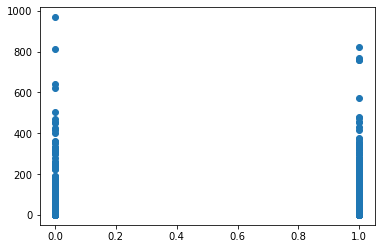

In [160]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [147]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

,OR (95% CI),p-value
eth_white,NaN,NaN
lang_ENGL,0.671 (0.565 to 0.796),0.000


Text(0, 0.5, 'p-val')

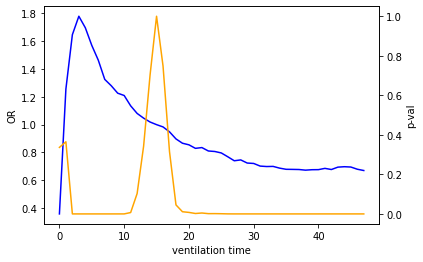

In [152]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


mean English: 17.393959748056293
mean non-English: 20.82154938271605
t_test p-val;: 0.0003431489047810807


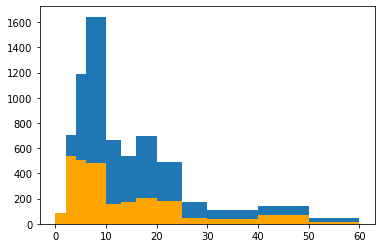

In [178]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))

0.0003431489047810807

## 2.1: DL Survival Analysis

In [ ]:
new_cols = ['Unnamed: 0','hadm_id','subject_id','gender','ethnicity','marital_status','insurance','language','aortic','mit','tricuspid',
            'pulmonary','cabg','temp','bg_temp','hr','spo2','rr','sbp','dbp','meanbp','weight','height','cardiac_index','pt','ptt',
            'inr','inr_1','fibrinogen','hb','hematocrit','plts','wcc','lymphocytes','neutrophils','alp','ast','alt','ggt',
            'bilirubin_indirect','bilirubin_direct','bilirubin_total','chloride','magnesium','potassium','crp','bleed_time','albumin',
            'creatinine','free_calcium','sodium','bicarb','bun','hba1c','glucose','lactate','po2','pco2','baseexcess','ph','aado2',
            'fio2','ffp','insulin','cryo','prbc','infection','ventrate','tidalvol','vent_array','reintubation','liver_severe','liver_mild',
            'rheum','cvd','aids','ckd','copd','arrhythmia','pud','smoking','pvd','paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi',
            'dementia','first_careunit','last_careunit','admission_location','admission_type','hospital_expire_flag','admittime',
            'dischtime','intime','outtime','ext_time','reint_time','los','icustay_seq','deathtime','plt','diab_un','diab_cc',
            'dtoutput','specimen','dod']

# variables for analysis
timeSeriesMMM=[]
for column in timeseries:
    for a in ['_mean','_max','_min']:
        timeSeriesMMM.append(column+a)
input_cols = ['gender','ethnicity','marital_status','insurance','language','aortic','mit','tricuspid',
            'pulmonary','cabg','weight','height','liver_severe','liver_mild','rheum','cvd','aids','ckd','copd','arrhythmia',
            'pud','smoking','pvd','paraplegia','ccf','met_ca','t2dm','t1dm','malig','mi','dementia','first_careunit',
            'admission_location','admission_type','diab_un','diab_cc',*timeSeriesMMM]
outcome_cols = ['reintubation','hospital_expire_flag','los','duration1','duration2']
others = ['admittime','dischtime','intime','outtime','ext_time','reint_time','deathtime','icustay_seq','dtoutput','specimen','dod',
        'int_time1','ext_time1','int_time2','ext_time2']


In [181]:
templist=[]
for column in timeseries:
    for a in ['_mean','_max','_min']:
        templist.append(column+a)
print(templist)

['temp_mean', 'temp_max', 'temp_min', 'bg_temp_mean', 'bg_temp_max', 'bg_temp_min', 'hr_mean', 'hr_max', 'hr_min', 'spo2_mean', 'spo2_max', 'spo2_min', 'rr_mean', 'rr_max', 'rr_min', 'sbp_mean', 'sbp_max', 'sbp_min', 'dbp_mean', 'dbp_max', 'dbp_min', 'meanbp_mean', 'meanbp_max', 'meanbp_min', 'cardiac_index_mean', 'cardiac_index_max', 'cardiac_index_min', 'pt_mean', 'pt_max', 'pt_min', 'ptt_mean', 'ptt_max', 'ptt_min', 'inr_mean', 'inr_max', 'inr_min', 'inr_1_mean', 'inr_1_max', 'inr_1_min', 'fibrinogen_mean', 'fibrinogen_max', 'fibrinogen_min', 'hb_mean', 'hb_max', 'hb_min', 'hematocrit_mean', 'hematocrit_max', 'hematocrit_min', 'plts_mean', 'plts_max', 'plts_min', 'wcc_mean', 'wcc_max', 'wcc_min', 'lymphocytes_mean', 'lymphocytes_max', 'lymphocytes_min', 'neutrophils_mean', 'neutrophils_max', 'neutrophils_min', 'alp_mean', 'alp_max', 'alp_min', 'ast_mean', 'ast_max', 'ast_min', 'alt_mean', 'alt_max', 'alt_min', 'ggt_mean', 'ggt_max', 'ggt_min', 'bilirubin_indirect_mean', 'bilirubin_i